### Implement Linear Discriminant Analysis Algorithm and use for the classification of Iris Dataset.

In [96]:
from math import *
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#### (a) Plot the transformed dataset along with the corresponding class labels.

In [97]:
class LDA:
    def __init__(self, dim=None):
        self.dim = dim
    
    def transform(self, X, y):
        # number of features
        n = X.shape[1]
        
        # finding unique classes
        unique_classes = np.unique(y)
        
        mean_overall = np.mean(X, axis=0)
        # initialising scatter matrices
        SW = np.zeros((n, n))
        SB = np.zeros((n, n))
        
        for c in unique_classes:
            x = X[y == c]
            mean_c = np.mean(x, axis=0)
            SW += (x - mean_c).T.dot((x - mean_c))

            n_c = x.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)
            
        # SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        eigenValues, eigenVectors = np.linalg.eigh(A)
        eigenVectors = eigenVectors.T
        
        # sort eigen values from high to low
        ind = np.argsort(abs(eigenValues))[::-1]
        eigenValues = eigenValues[ind]
        eigenVectors = eigenVectors[ind]
        
        # store first n eigenvectors
        ld = eigenVectors[0:self.dim]
        transformed_x = np.dot(X, ld.T)
        
        if self.dim == 2:

            labels = np.unique(y)
            colors =  ['r','g','b']
            for color, label in zip(colors, labels):
                class_data = transformed_x[np.flatnonzero(y==label)]
                plt.scatter(class_data[:,0],class_data[:,1],c=color)
            plt.show()
            
        return transformed_x

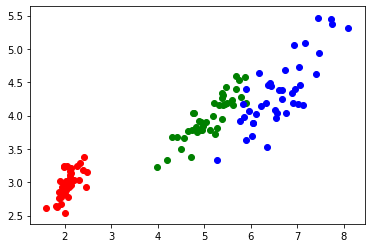

Original Data Size: (120, 4) 
Modified Data Size: (120, 2)


In [98]:
lda = LDA(dim=2)
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

transformed_X_train = lda.transform(X_train, Y_train)

print("Original Data Size:",X_train.shape, "\nModified Data Size:", transformed_X_train.shape)

#### (b) Use bayes classifier for classification and compare results with that of PCA.

In [99]:
# Bayes classification
model = GaussianNB()
X_train, X_test, Y_train,  Y_test = train_test_split(transformed_X_train, Y_train, test_size=0.2)
model.fit(X_train, Y_train)

predictions = model.predict(X_test)
lda_accuracy = accuracy_score(Y_test, predictions)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.82      1.00      0.90         9
           2       1.00      0.71      0.83         7

    accuracy                           0.92        24
   macro avg       0.94      0.90      0.91        24
weighted avg       0.93      0.92      0.91        24



In [100]:
# PCA implementation
iris = pd.read_csv("iris.data", header=None)

# clean data by removing rows with blank values
def cleanData(data):
    data = data.replace('-', np.nan)
    data = data.replace('', np.nan)
    data = data.dropna()
    return data

def dropColumns(data):
    data = data.drop(data.columns[-1], axis=1)
    return data

def eigenDecomposition(cov):
    # finding eigen values & eigen vectors
    eigenValues, eigenVectors = np.linalg.eig(cov)
    return eigenValues, eigenVectors


def modifiedVariance(eigenValues):
    var = eigenValues / np.sum(eigenValues)
    return var


def bestVectors(n, variances, eigenVectors):
    features = []
    for _ in range(n):
        temp = np.argmax(variances)
        features.append(temp)
        variances[temp] = 0
    return eigenVectors[:, features]


def principalComponents(vectors, data):
    return np.dot(vectors.T, data.T).T

# removing unecessary values
iris = cleanData(iris)
results = iris[4]
data = dropColumns(iris)
dataMatrix = data.values

# finding mean
means = np.mean(dataMatrix, axis=0)
# subtracting mean
dataMatrix = dataMatrix-means

# finding covariance
cov = np.cov(dataMatrix.T)

eigenValues, eigenVectors = eigenDecomposition((len(dataMatrix)-1)*cov)
variances = modifiedVariance(eigenValues)

# finding top vectors
vectors = bestVectors(3, variances, eigenVectors)

PC1 = principalComponents(vectors, dataMatrix)

model = GaussianNB()
X_train, X_test, Y_train,  Y_test = train_test_split(PC1, results.ravel(), test_size=0.2)
model.fit(X_train, Y_train)

predictions = model.predict(X_test)
pca_accuracy = accuracy_score(Y_test, predictions)
print(classification_report(Y_test, predictions))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       0.89      0.80      0.84        10
 Iris-virginica       0.80      0.89      0.84         9

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.89        30
   weighted avg       0.90      0.90      0.90        30



In [101]:
print("Accuracy for LDA: ", lda_accuracy)
print("Accuracy for PCA: ", pca_accuracy)

if(lda_accuracy >= pca_accuracy):
    print("\nLDA performs better than PCA.")
else:
    print("\nPCA performs better than LDA.")

Accuracy for LDA:  0.9166666666666666
Accuracy for PCA:  0.9

LDA performs better than PCA.
